In [1]:
import os
import time
import tqdm
import random
import skimage
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from config import Config
from acne_data import AcneSegDataset, transforms, expand_mask
import visualize
import utils

In [2]:
cfg = Config()

data_train = AcneSegDataset(cfg.DATA_BASE_DIR, 'train', cfg, transforms(cfg.RGB_MEAN, cfg.RGB_STD, 'train'))

# 背景 丘疹 痣 节结
# 开口粉刺 闭口粉刺
# 萎缩性瘢痕 肥厚性瘢痕
# 黄褐斑 脓疱 其它
categories = ['BG', 'papule', 'nevus', 'nodule',
              'open_comedo', 'closed_comedo',
              'atrophic_scar', 'hypertrophic_scar',
              'melasma', 'pustule', 'other']
category_to_id = {c: i for i, c in enumerate(categories)}

loading annotations into memory...
Done (t=1.25s)
creating index...
index created!


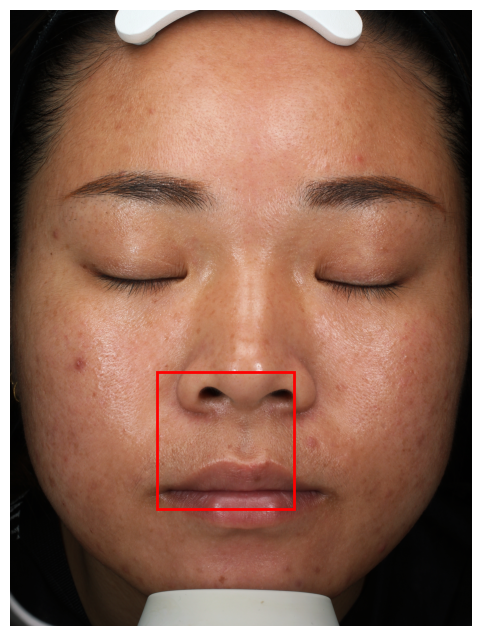

In [4]:
idx = random.randint(0, len(data_train) - 1)
image_patch, image_meta, rpn_matches, rpn_deltas, gt_class_ids, gt_bboxes, gt_masks = data_train[idx]
image_meta = image_meta.numpy()
img_id = image_meta[0]
shape = image_meta[1:4]
window = image_meta[-4:]

img_obj = data_train.coco.imgs[img_id]
img_path = os.path.join(cfg.DATA_BASE_DIR, 'images', img_obj['file_name'])
image = skimage.io.imread(img_path)

fig = plt.figure(figsize=(6, 8), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')
ax.imshow(image)
win = plt.Rectangle(xy=window[:2], width=window[2]-window[0], height=window[3]-window[1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(win)
fig.show()

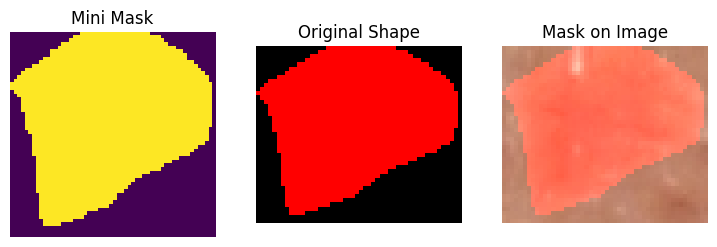

In [5]:
image_patch = image_patch.numpy().transpose((1, 2, 0))
image_patch = np.clip(((image_patch*cfg.RGB_STD)+cfg.RGB_MEAN)*255, 0, 255).astype(np.int32)

gt_class_ids = gt_class_ids.numpy()
gt_bboxes = gt_bboxes.numpy()
gt_masks = gt_masks.numpy().transpose((1, 2, 0))
idx = np.nonzero(gt_class_ids)[0]
gt_class_ids = gt_class_ids[idx]
gt_bboxes = gt_bboxes[idx, :]
gt_masks = gt_masks[:, :, idx]
num_labels = len(idx)

if cfg.USE_MINI_MASK:
    box = gt_bboxes[0].astype(np.int32)
    mask = gt_masks[:, :, 0]

    fig = plt.figure(figsize=(9, 3), dpi=100)

    ax = fig.add_subplot(1, 3, 1)
    ax.axis('off')
    ax.imshow(mask)
    ax.set_title('Mini Mask')

    refind_mask = expand_mask(box, mask, cfg.IMAGE_SHAPE[:2])
    image = image_patch[box[1]:box[3], box[0]:box[2], :]
    refind_mask = refind_mask[box[1]:box[3], box[0]:box[2]]
    mask = np.zeros(refind_mask.shape + (3,))
    mask[:, :, 0] = refind_mask
    image[mask > 0] = 255

    ax = fig.add_subplot(1, 3, 2)
    ax.axis('off')
    ax.imshow(mask)
    ax.set_title('Original Shape')

    ax = fig.add_subplot(1, 3, 3)
    ax.axis('off')
    ax.imshow(image)
    ax.set_title('Mask on Image')

    fig.show()

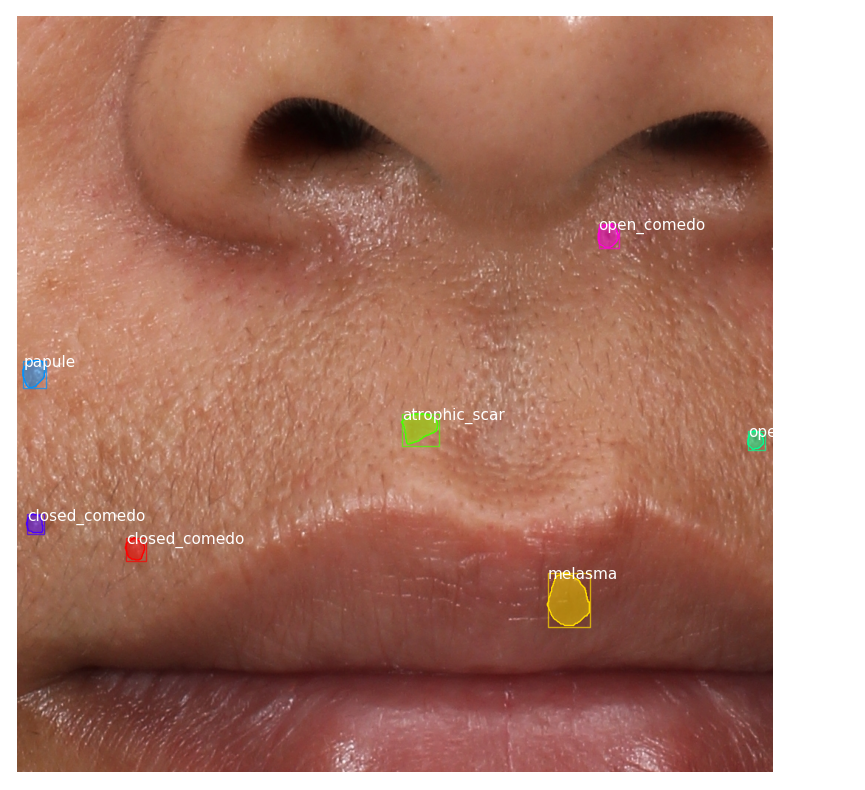

In [6]:
if cfg.USE_MINI_MASK:
    refined_masks = np.zeros(cfg.IMAGE_SHAPE[:2] + [num_labels])
    for i in range(num_labels):
        refined_masks[:, :, i] = expand_mask(gt_bboxes[i], gt_masks[:, :, i], cfg.IMAGE_SHAPE[:2])
    gt_masks = refined_masks

visualize.display_instances(image_patch, gt_bboxes, gt_masks, gt_class_ids, categories)

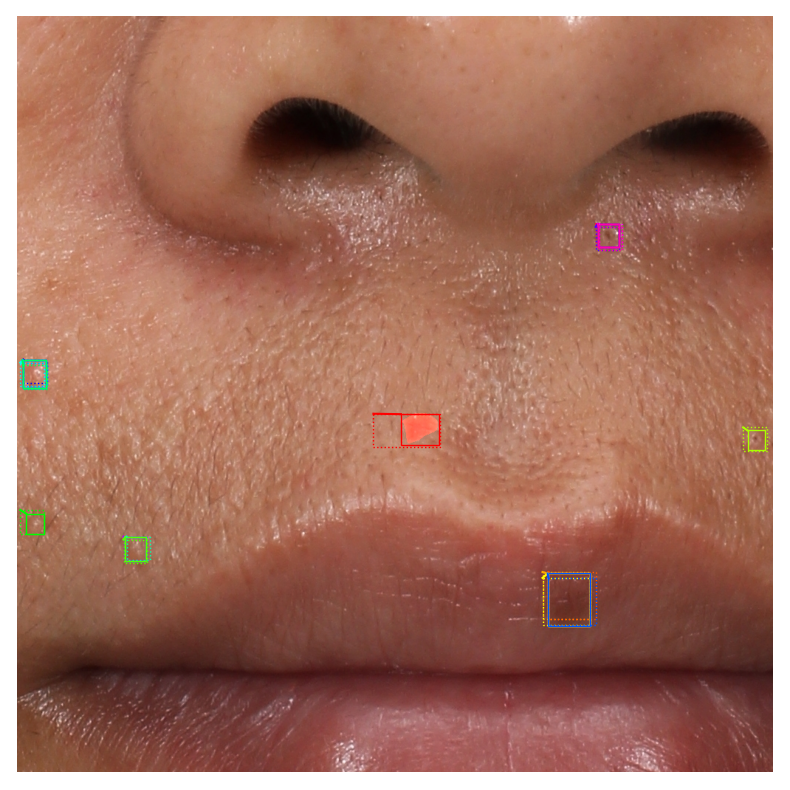

In [7]:
anchors = utils.generate_pyramid_anchors(cfg.RPN_ANCHOR_SCALES,
                                         cfg.RPN_ANCHOR_RATIOS,
                                         cfg.BACKBONE_SHAPES,
                                         cfg.BACKBONE_STRIDES,
                                         cfg.RPN_ANCHOR_STRIDE)
rpn_matches = rpn_matches.numpy()
idx = np.nonzero(rpn_matches == 1)[0]
matched_anchor = anchors[idx]
deltas = rpn_deltas.numpy()[:len(idx), :] * cfg.RPN_BBOX_STD_DEV
refined_anchors = utils.apply_box_deltas(torch.tensor(matched_anchor),
                                        torch.tensor(deltas)).numpy()

visualize.draw_boxes(image_patch, boxes=matched_anchor, refined_boxes=refined_anchors)
